In [1]:
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt

from swim import LJ, simple_md3d

#### Initialize system

In [2]:
m = 3
spacing = 3.
L = m * spacing
x_ref = np.linspace(-L/2, L/2, m, endpoint=False) + spacing/2
position = np.array(list(itertools.product(x_ref, repeat=3)))

num_particles = 24
init_x3d = position[:num_particles]
init_v3d = np.random.rand(num_particles,3)[:num_particles]

kT = 1.0

#### Set up Lennard-Jones potential

In [3]:
lj = LJ()
lj.param = {'epsilon':1.3, 
            'sigma':1.2, 
            'r_cut': 6*1.2}

#### Run MD

In [4]:
start = time.time()

md = simple_md3d(seed=45932)
md.set_param(dt=0.01,
             kT=kT, 
             damping=10.)
md.set_init_config(init_x3d=init_x3d,
                   init_v3d=init_v3d,
                   num_particles=num_particles,
                   box=[L, L+2, L])

# initialize velocity with kT
md.init_v3d = md.v_rescale(init_v3d, kT)

md.pe = lj
md.run(int(3e3))

print(time.time() - start, 's')

32.09401869773865 s


#### Use gsd to store trajectory. The gsd file can be visualized using Ovito.

In [5]:
import gsd.hoomd

def create_snapshot(timestep):
    
    d = 1.0
    N_particles = md.num_particles
    position = md.traj[timestep][1]
    
    snapshot = gsd.hoomd.Snapshot()
    
    snapshot.particles.types = ['A']
    snapshot.particles.N = N_particles
    snapshot.particles.typeid = [0] * N_particles
    
    snapshot.particles.position = position
    snapshot.particles.diameter = [d] * N_particles

    snapshot.configuration.box = [md.box[0], md.box[1], md.box[2], 0, 0, 0]
    snapshot.configuration.step = md.traj[timestep][0]
    
    return snapshot

f = gsd.hoomd.open(name='./md3d_traj.gsd', mode='wb+')

for i in range(len(md.traj)):
    snapshot = create_snapshot(i)
    f.append(snapshot)

#### Take a look at the trajectory of kinetic and potential energy

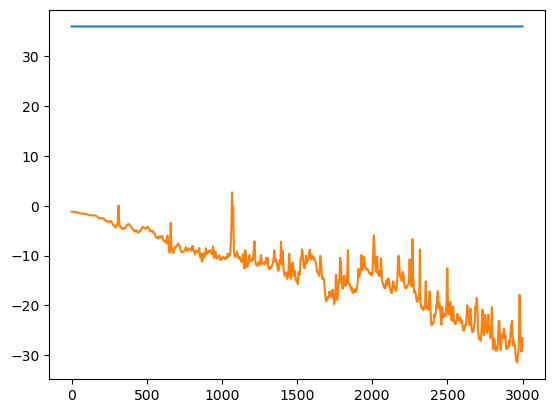

In [6]:
traj_ke = []
for i in range(len(md.traj)):
    ke = 0.5 * np.sum(md.traj[i][2]**2)
    traj_ke.append( ke )

plt.plot(traj_ke)
plt.plot(md.traj_pe)